# Modeling the Model

Lets see exactly where we end up with the most/least error

In [1]:
import os

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, trim_mean, pearsonr
from astropy import stats as asp
from astropy.utils import NumpyRNGContext

from optpresso import __file__ as optpresso_path
from optpresso.utils import GroundsLoader
from optpresso.models.eval import predict_values
from optpresso.data.partition import find_test_paths

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error

from optpresso.models.serialization import load_model
from optpresso.data.config import load_config

from IPython.core.display import display

In [2]:
# Because GPUs aren't that much faster for inference
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
plt.rcParams["figure.dpi"] = 150
TRAINING_DIR = os.path.expanduser("~/coffee-images/train/")
DATA_DIR = os.path.expanduser("~/coffee-images/test")

config = load_config()
if config is None:
    print("Invalid config, call optpresso init")
    raise ValueError("Invalid config")
model_path = config.model
model = load_model(model_path, compile=False)

loader = GroundsLoader(256, (model.input_shape[1], model.input_shape[2]), directory=DATA_DIR)

In [3]:
paths, y_true, y_pred = predict_values(model, loader)

In [4]:
images_by_time = defaultdict(list)
for time, img_path in find_test_paths(TRAINING_DIR):
    images_by_time[time].append(img_path)

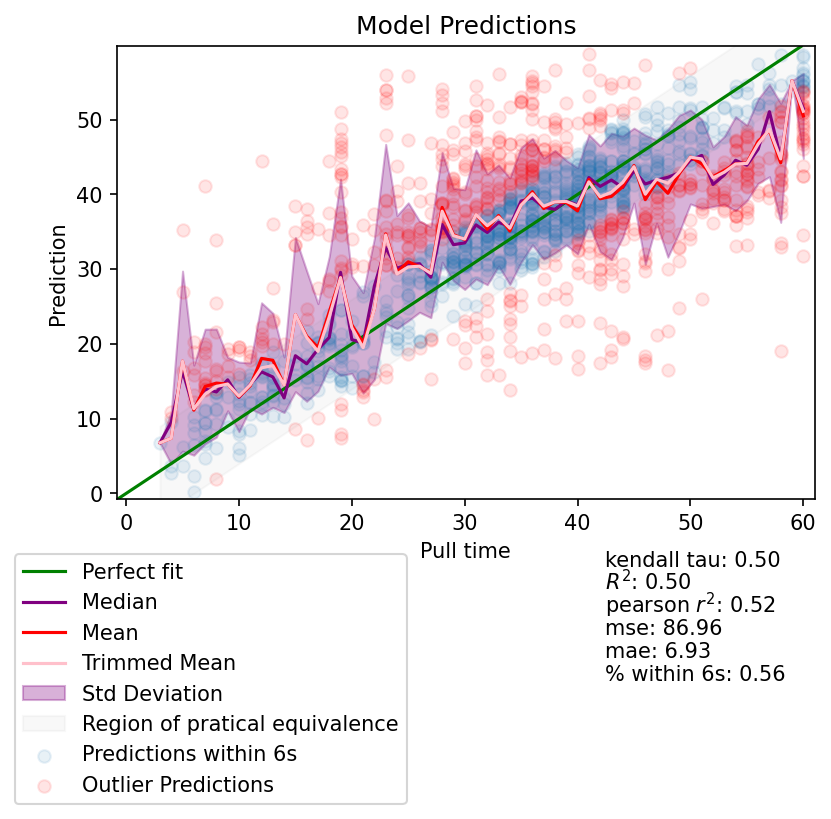

In [5]:
bins = defaultdict(list)
for real, pred in zip(y_true, y_pred):
    bins[real].append(pred)
x = np.zeros(len(bins))
y = np.zeros_like(x)
meds = np.zeros_like(x)
trimmed_mean = np.zeros_like(x)
deviations = np.zeros_like(x)
areas_missed_by_std = np.zeros(len(bins), dtype=np.bool)
areas_missed_by_rope = np.zeros(len(bins), dtype=np.bool)
for i, (time, predictions) in enumerate(sorted(bins.items(), key=lambda x: x[0])):
    x[i] = time
    y[i] = np.mean(predictions)
    meds[i] = np.median(predictions)
    trimmed_mean[i] = trim_mean(predictions, proportiontocut=0.1)
    deviations[i] = np.std(predictions)
    areas_missed_by_std[i] = deviations[i] < abs(y[i] - time)
    areas_missed_by_rope[i] = 6 < abs(y[i] - time)
abs_diff = np.abs(y_true - y_pred)
good_mask = np.argwhere(abs_diff < 6)
outlier_mask = np.argwhere(abs_diff > 6)
fig, ax = plt.subplots(dpi=150)
ax.axline([0, 0], [1, 1], color="g", label="Perfect fit")
ax.plot(x, meds, color="purple", label="Median")
ax.plot(x, y, color="red", label="Mean")
ax.plot(x, trimmed_mean, color="pink", label="Trimmed Mean")
ax.fill_between(x, (y-deviations), (y+deviations), linestyle="None", color="purple", alpha=.3, label="Std Deviation")
ax.fill_between(x, (x-6), (x+6), color='gray', alpha=.05, label="Region of pratical equivalence")
ax.scatter(y_true[good_mask], y_pred[good_mask], alpha=.1, label="Predictions within 6s")
ax.scatter(y_true[outlier_mask], y_pred[outlier_mask], alpha=.1, label="Outlier Predictions", color="r")
ax.set_ylabel("Prediction")
ax.set_xlabel("Pull time")
ax.set_title("Model Predictions")
fig.legend(bbox_to_anchor=(0, -.4), loc='lower left')
ax.set_xlim(min(np.min(y_pred), np.min(x)) - 1, np.max(x)+1)
ax.set_ylim(min(np.min(y_pred), np.min(x)) - 1, max(np.max(y_pred), np.max(y)) + 1)
model_stats = {
    "kendall tau": kendalltau(y_true, y_pred)[0],
    "$R^2$": r2_score(y_true, y_pred),
    "pearson $r^2$": pearsonr(y_true, y_pred)[0]**2,
    "mse": mean_squared_error(y_true, y_pred),
    "mae": mean_absolute_error(y_true, y_pred),
    "% within 6s": len(y_true[good_mask]) / len(y_true),
}
for i, (name, stat) in enumerate(model_stats.items()):
    ax.annotate(
        f"{name}: {stat:.2f}",
        (0.7, -0.15 - 0.05 * i),
        xycoords="axes fraction"
    )

plt.show()

### Evalute where Model performed poorly

Compare both the mean prediction value per pull time and see if the Standard deviation accounts for the error or if the Region of Practical Equivalence (ROPE) of 6 seconds is enough to account for the error in the mean prediction for a pull time.

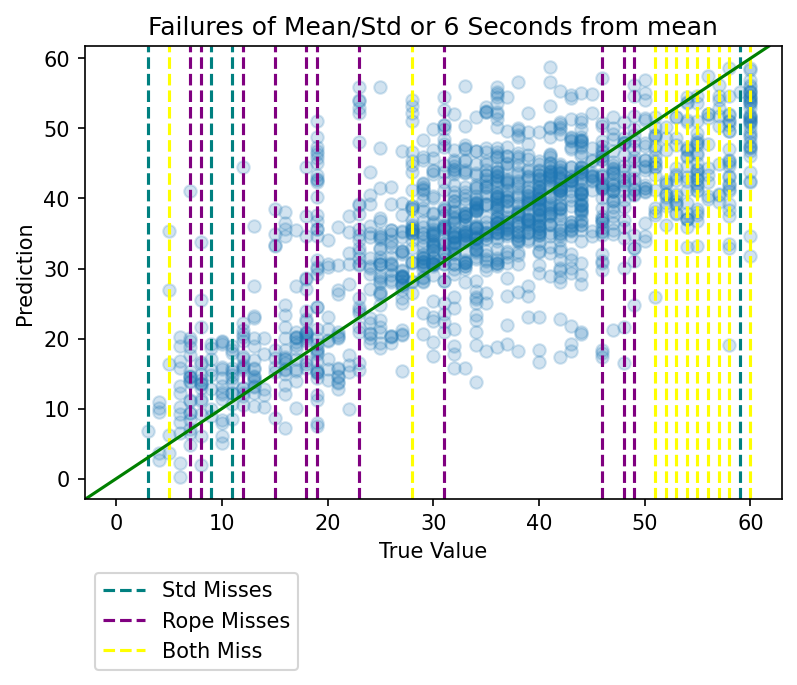

In [6]:
both = []
std_misses = []
rope_misses = []
for data, missed_std, missed_roped in zip(x, areas_missed_by_std, areas_missed_by_rope):
    if missed_std and missed_roped:
        both.append(data)
    elif missed_std:
        std_misses.append(data)
    elif missed_roped:
        rope_misses.append(data)
plt.scatter(y_true, y_pred, alpha=0.2)
std_miss = None
rope_miss = None
both_miss = None
for miss in std_misses:
    std_miss = plt.axvline(miss, color="teal", linestyle="--", label="Std Misses")
for miss in rope_misses:
    rope_miss = plt.axvline(miss, color="purple", linestyle="--", label="Rope Misses")
for miss in both:
    both_miss = plt.axvline(miss, color="yellow", linestyle="--", label="Both Miss")
plt.axline([0, 0], [1, 1], color="g", label="Perfect fit")
labels = []
handles = []
if std_miss is not None:
    handles.append(std_miss)
    labels.append("Std Misses")
if rope_miss is not None:
    handles.append(rope_miss)
    labels.append("Rope Misses")
if both_miss is not None:
    handles.append(both_miss)
    labels.append("Both Miss")
plt.legend(handles, labels, bbox_to_anchor=(0, -.4), loc='lower left')
plt.title("Failures of Mean/Std or 6 Seconds from mean")
plt.ylabel("Prediction")
plt.xlabel("True Value")
plt.show()

Median 227.56294775009155
Mean 252.34545468223558
Trimmed mean 226.51940113479293
Best Statistic by Area under the curve is Trimmed mean


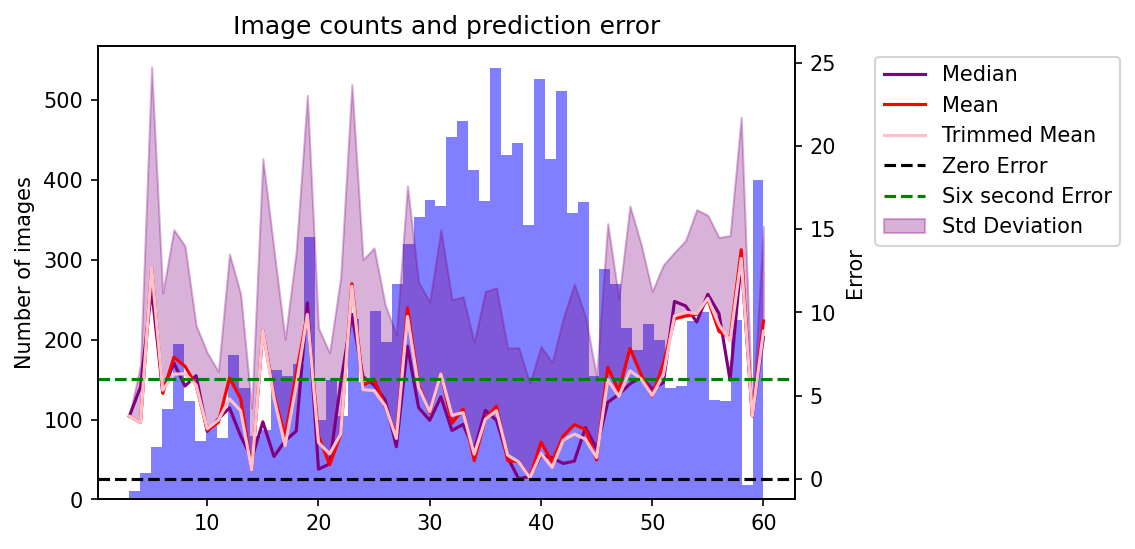

In [7]:
counts = []
for key, val in images_by_time.items():
    counts.append((key, len(val)))
means = np.zeros_like(y)
meds = np.zeros_like(x)
trimmed_mean = np.zeros_like(x)
deviations = np.zeros_like(x)
for i, (time, predictions) in enumerate(sorted(bins.items(), key=lambda x: x[0])):
    means[i] = np.abs(np.mean(predictions) - time)
    meds[i] = np.abs(np.median(predictions) - time)
    trimmed_mean[i] = np.abs(trim_mean(predictions, proportiontocut=0.1) - time)
    deviations[i] = np.std(predictions)
data = []
for key, val in images_by_time.items():
    for _ in range(len(val)):
        data.append(key)
plt.hist(
    data,
    len(images_by_time),
    color="blue",
    stacked=True,
    label="Counts",
    alpha=0.5
)
axe = plt.gca()
axe.set_ylabel("Number of images")
axe_2 = plt.twinx()
axe_2.plot(x, meds, color="purple", label="Median")
axe_2.plot(x, means, color="red", label="Mean")
axe_2.plot(x, trimmed_mean, color="pink", label="Trimmed Mean")
axe_2.fill_between(x, means, (means+deviations), linestyle="None", color="purple", alpha=.3, label="Std Deviation")
axe_2.set_ylabel("Error")
axe_2.axhline(0, label="Zero Error", linestyle="--", color="black")
axe_2.axhline(6, label="Six second Error", linestyle="--", color="green")
plt.xlabel("Pull time")
best = None
for name, vals in [("Median", meds), ("Mean", means), ("Trimmed mean", trimmed_mean)]:
    area_under_curve = np.trapz(x, vals)
    print(name, area_under_curve)
    if best is None or best[1] > area_under_curve:
        best = (name, area_under_curve)
print(f"Best Statistic by Area under the curve is {best[0]}")
plt.title(f"Image counts and prediction error")
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
plt.show()

-0.6707628956214076 9.335400893654151


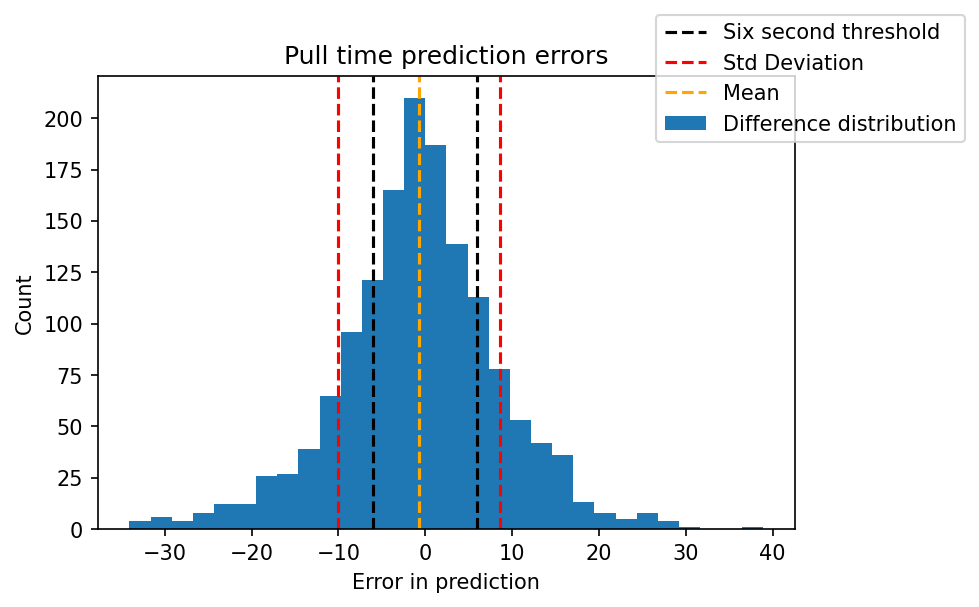

In [8]:
diff = y_true - y_pred
threshold = 6
fig, axe = plt.subplots(dpi=150)
n, hist_bins, patches = axe.hist(diff, bins=30, label="Difference distribution")
plt.title("Pull time prediction errors")
plt.xlabel("Error in prediction")
plt.ylabel("Count")
axe.axvline(threshold, color="black", linestyle="--", label="Six second threshold")
axe.axvline(-threshold, color="black", linestyle="--")
mids = 0.5*(hist_bins[1:] + hist_bins[:-1])
mean = np.average(mids, weights=n)
var = np.average((mids - mean)**2, weights=n)
std = np.sqrt(var)
axe.axvline(mean + std, color="red", linestyle="--", label="Std Deviation")
axe.axvline(mean-std, color="red", linestyle="--")
axe.axvline(mean, color="orange", linestyle="--", label="Mean")
print(mean, std)
fig.legend(bbox_to_anchor=(1.1, 1), loc='upper right')
plt.show()

In [9]:
stacked_data = np.dstack((paths, y_true, y_pred))
stacked_data.resize(len(paths), 3)
sort = np.argsort(stacked_data[:,1])
sorted_data = stacked_data[sort]

### Investigate the inability to distinguish between 30s and 50s shots

A problem I have noticed is that the model has issues learning the difference between a 30 second shot and a 50 second shot. This investigated the point at which that distinction has the biggest impact on the MSE/MAD.

The following two cells look at cutting off from low to high (cut off at 10 seconds, then 15, etc) then high to low (cut off 60 seconds, then 55, etc) to see the impact of on the statistics.

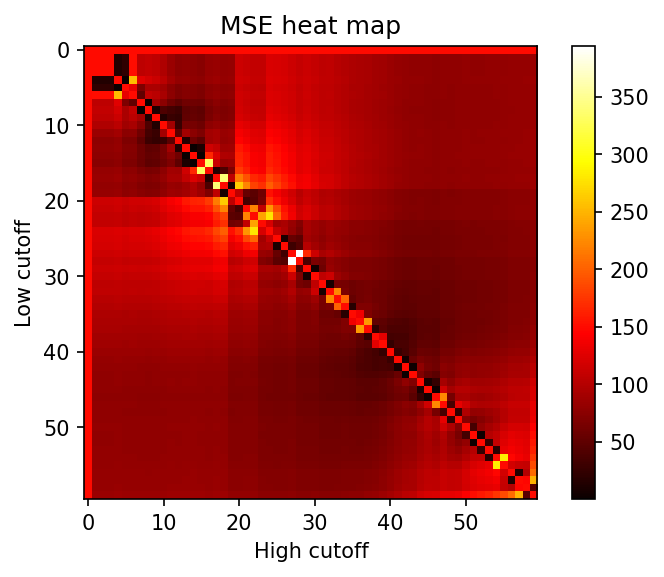

Cutoff with lowest MSE (7.0, 8.0, 0.0015781755209900439)


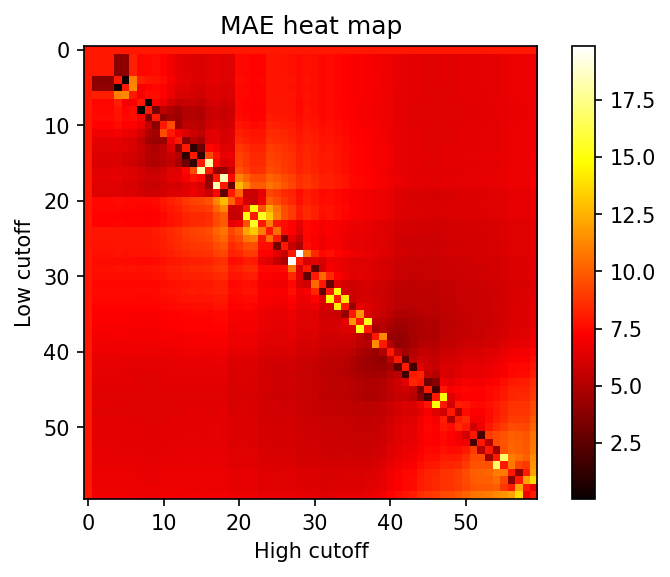

Cutoff with lowest MAE (7.0, 8.0, 0.03972625732421875)


In [10]:
x = np.arange(0, max(sorted_data[:, 1]), 1)
y = np.arange(max(sorted_data[:, 1]) - 1, 0, -1)
mse_data = np.ones((len(x), len(x))) * 150
mad_data = np.ones_like(mse_data) * 8
min_mse_cutoff = None
min_mad_cutoff = None
for high_cutoff in x:
    for low_cutoff in y:
        if low_cutoff > high_cutoff:
            continue
        high_idx = 0
        for i in range(len(paths)):
            if sorted_data[i][1] >= high_cutoff:
                high_idx = i
                break
        low_idx = 0
        for i in reversed(range(len(paths))):
            if sorted_data[i][1] <= low_cutoff:
                low_idx = i
                break
        trimmed_x = sorted_data[:,1][low_idx:high_idx]
        trimmed_y = sorted_data[:,2][low_idx:high_idx]
        if not len(trimmed_x):
            continue
        mse = mean_squared_error(trimmed_x, trimmed_y)
        mae = mean_absolute_error(trimmed_x, trimmed_y)
        mse_data[int(high_cutoff), int(low_cutoff)] = mse_data[int(low_cutoff), int(high_cutoff)] = mse
        mad_data[int(high_cutoff), int(low_cutoff)] = mad_data[int(low_cutoff), int(high_cutoff)] = mae
        if min_mse_cutoff is None or mse < min_mse_cutoff[2]:
            min_mse_cutoff = (low_cutoff, high_cutoff, mse)
        if min_mad_cutoff is None or mae < min_mad_cutoff[2]:
            min_mad_cutoff = (low_cutoff, high_cutoff, mae)
plt.imshow(mse_data, cmap="hot", interpolation="nearest")
plt.xlabel("High cutoff")
plt.ylabel("Low cutoff")
plt.title("MSE heat map")
plt.colorbar()
plt.show()
print("Cutoff with lowest MSE", min_mse_cutoff)


plt.imshow(mad_data, cmap="hot", interpolation="nearest")
plt.xlabel("High cutoff")
plt.ylabel("Low cutoff")
plt.title("MAE heat map")
plt.colorbar()
plt.show()
print("Cutoff with lowest MAE", min_mad_cutoff)